In [9]:
!pip install -r requirements.txt

In [10]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

In [11]:
import cv2
import os

In [12]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [13]:
latent_dim = 128
image_size = 128
images = []

In [14]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}. Skipping.")
        return []

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(
        grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(40,40)
    )

    crops = []
    for (x, y, w, h) in faces:
        x_max = min(img.shape[1], x + w)
        y_max = min(img.shape[0], y + h)
        x = max(0, x)
        y = max(0, y)

        if w <= 0 or h <= 0:
            continue

        im_cropped = img[y:y_max, x:x_max]
        if im_cropped.size == 0:
            continue

        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
        im_cropped = im_cropped.astype("float32") / 255.0
        crops.append(im_cropped)

    return crops

In [15]:
i = 0
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= 13000:
            break
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            processed_crops = preprocess_image(img_path)
            if len(processed_crops) == 0:
                continue
            for crop in processed_crops:
                images.append(crop)
                i += 1
                if i >= 13000:
                    break

In [16]:
!pip show tensorflow

Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/e20210007813/Bureau/ProjImage/face_filters/.venv/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 


In [17]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (10400, 128, 128, 3)
Test shape: (2600, 128, 128, 3)


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

2025-11-26 09:20:48.961308: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Matplotlib is building the font cache; this may take a moment.


In [32]:

from keras.saving import register_keras_serializable


# --- Residual Block ---
def residual_block(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding="same")(shortcut)
    
    x = layers.Conv2D(filters, 3, strides=strides, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

# --- Encoder ---
encoder_inputs = Input(shape=(128,128,3))

x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)  # primer downsampling
x = residual_block(x, 32, strides=2)  # 64x64 -> 32x32
x = residual_block(x, 64, strides=2)  # 32x32 -> 16x16
x = residual_block(x, 128, strides=2) # 16x16 -> 8x8

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

@register_keras_serializable()
def sampling(args):
    mean, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      4,640 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │        544 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ conv2d_18[0][0],  │
│                     │ 32)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │     18,496 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_20[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │      2,112 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ conv2d_21[0][0],  │
│                     │ 64)               │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 16,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_24[0][0],  │
│                     │                   │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 8, 8, 128) │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ activation_5[0][

 Total params: 2,465,376 (9.40 MB)

 Trainable params: 2,465,376 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# from keras.saving import register_keras_serializable

# encoder_inputs = keras.Input(shape=(128, 128, 3))

# x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
# x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
# x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
# x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)

# x = layers.Flatten()(x)
# x = layers.Dense(256, activation="relu")(x)

# z_mean = layers.Dense(latent_dim)(x)
# z_log_var = layers.Dense(latent_dim)(x)


# @register_keras_serializable()
# def sampling(args):
#     mean, log_var = args
#     epsilon = tf.random.normal(shape=tf.shape(mean))
#     return mean + tf.exp(0.5 * log_var) * epsilon

# z = layers.Lambda(sampling)([z_mean, z_log_var])

# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()


In [33]:
decoder_inputs = Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 128))(x)

# UpSampling + Conv blocks (reduce checkerboard / mejora detalles)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(16, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Salida final en [0,1] usando sigmoid (más directo para MAE/MSE)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 128, 128, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,302,627 (4.97 MB)

 Trainable params: 1,302,147 (4.97 MB)

 Non-trainable params: 480 (1.88 KB)

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

beta = 0.5
gamma = 0.1  # peso de la perceptual loss

# --- Preparar modelo VGG para perceptual loss ---
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
layer_names = ['block3_conv3', 'block4_conv3']
vgg_outputs = [vgg.get_layer(name).output for name in layer_names]
vgg_model = Model(inputs=vgg.input, outputs=vgg_outputs)

def perceptual_loss(x_true, x_pred):
    # VGG espera imágenes en [0,255], actualmente tus imágenes están en [0,1]
    x_true_pp = preprocess_input(x_true * 255.0)
    x_pred_pp = preprocess_input(x_pred * 255.0)
    
    features_true = vgg_model(x_true_pp)
    features_pred = vgg_model(x_pred_pp)
    
    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += tf.reduce_mean(tf.square(f_true - f_pred))
    return loss

# --- Clase VAE ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstruction = self.decoder(z, training=True)  # [0,1]

            # Reconstrucción MAE + SSIM
            mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
            ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
            ssim_loss = 1.0 - ssim
            recon_loss = tf.reduce_mean(mae + 0.5 * ssim_loss)

            # KL divergence
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            # Perceptual loss
            p_loss = perceptual_loss(x, reconstruction)

            total_loss = recon_loss + beta * kl_loss + gamma * p_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss,
                "perceptual_loss": p_loss}

    def test_step(self, x):
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)

        mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
        ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
        ssim_loss = 1.0 - ssim
        recon_loss = tf.reduce_mean(mae + 0.5 * ssim_loss)

        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        p_loss = perceptual_loss(x, reconstruction)
        total_loss = recon_loss + beta * kl_loss + gamma * p_loss

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss,
                "perceptual_loss": p_loss}

    def call(self, x):
        _, _, z = self.encoder(x)
        return self.decoder(z)

In [44]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=None)

In [45]:
class SaveEveryN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            vae.build((None,) + x_train.shape[1:])
            print(f"\n🔽 Saving VAE on epoch {epoch+1}...")
            vae.encoder.save(f"../Models/Temp/vae_encoder_epoch_{epoch+1}.keras")
            vae.decoder.save(f"../Models/Temp/vae_decoder_epoch_{epoch+1}.keras")
            vae.save_weights(f'../Models/Temp/vae_weights_epoch_{epoch+1}.weights.h5')

In [ ]:
# Train the vae
epochs = 50
batch_size = 32

history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, None),
    callbacks=[SaveEveryN()]
)
vae.build((None,) + x_train.shape[1:])


Epoch 1/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - kl_loss: 356.1013 - loss: 5669.5264 - perceptual_loss: 54913.0000 - reconstruction_loss: 0.1754 - val_kl_loss: 332.4555 - val_loss: 5327.5322 - val_perceptual_loss: 51611.1914 - val_reconstruction_loss: 0.1853
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - kl_loss: 358.6491 - loss: 5287.3013 - perceptual_loss: 51078.0859 - reconstruction_loss: 0.1680 - val_kl_loss: 322.7797 - val_loss: 5350.5127 - val_perceptual_loss: 51889.3438 - val_reconstruction_loss: 0.1883
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - kl_loss: 362.0079 - loss: 4828.8384 - perceptual_loss: 46476.6758 - reconstruction_loss: 0.1671 - val_kl_loss: 338.0101 - val_loss: 5404.8262 - val_perceptual_loss: 52356.4102 - val_reconstruction_loss: 0.1800


In [47]:
vae.encoder.save( "../Models/vae_encoder.keras")
vae.decoder.save( "../Models/vae_decoder.keras")

vae.save_weights('../Models/vae_weights.weights.h5')

In [27]:
# encoder = keras.models.load_model("../Models/vae_encoder_300epochs.keras", compile=False, safe_mode=False)
# decoder = keras.models.load_model("../Models/vae_decoder_300epochs.keras", compile=False, safe_mode=False)

# vae = VAE(encoder, decoder)

# vae.build((None,) + x_train.shape[1:])
# vae.load_weights("../Models/vae_weights_300epochs.weights.h5")

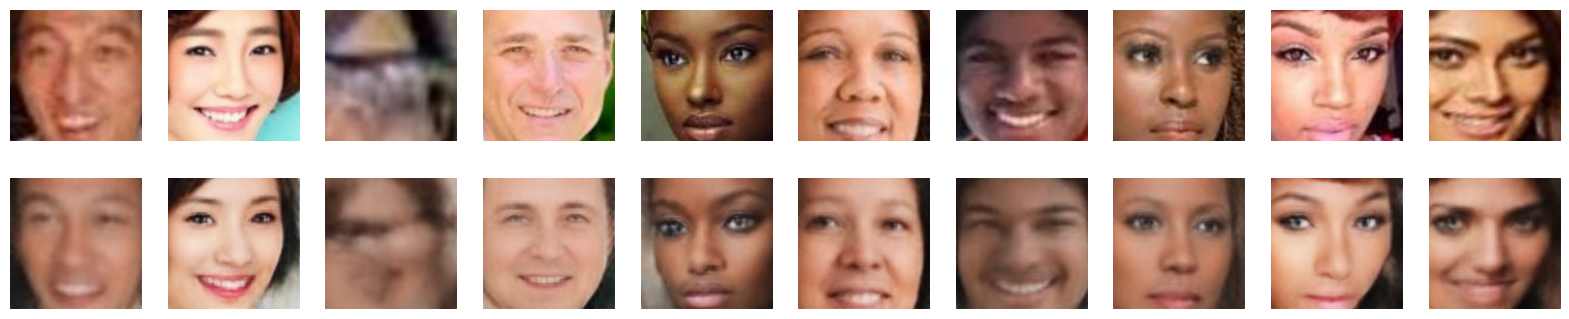

In [48]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt

n = 10

# El encoder devuelve: z_mean, z_log_var, z
z_mean, z_log_var, z = vae.encoder(x_test[:n])
decoded_imgs = vae.decoder(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")

plt.show()

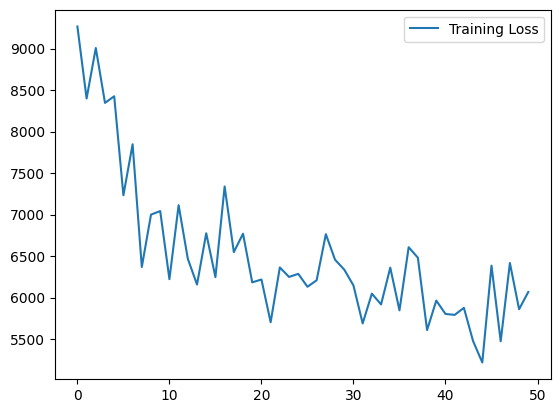

In [29]:
loss = history.history['loss']

epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')
plt.legend()
plt.show()

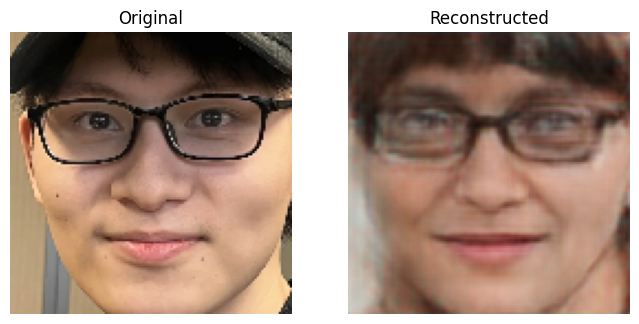

In [54]:
img_path = "../Images/XH.jpg"

# Preprocess
face = preprocess_image(img_path)[1]
face_batch = np.expand_dims(face, axis=0)  # shape (1, H, W, C)

# Encode & decode
z_mean, z_log_var, z = vae.encoder(face_batch)
decoded_imgs = vae.decoder(z)  # still a batch of 1

# Plot original vs reconstructed
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(face)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[0])
plt.title("Reconstructed")
plt.axis("off")

plt.show()